In [38]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
%matplotlib widget

##Define constants and rotation matrices for 2D drone


In [39]:
#Parametros consantes:
g = 9.81 #m/s**2
m = 0.468 #kg
l = 0.225 #m arm of the motors to the center of gravity
k = 2.980 * 1e-6 #Constante de lift
b = 1.140 * 1e-7 #Constante de drag (para torque en psi, en z inercial
c_d = 0.0 #Coeficiente de drag traslacional
I_yy = 4.856 * 1e-3 #Inercia del dron completo
A_x = A_z = 0.25  #Constantes del drag traslacional inercial


# PID Controller class

In [40]:
# PID Controller
class PIDController:
    def __init__(self, Kp, Ki, Kd):
        self.Kp, self.Ki, self.Kd = Kp, Ki, Kd
        self.last_error = None
        self.integral = 0

    def compute(self, measurement, dt, setpoint):
        error = setpoint - measurement
        self.integral += error * dt

        if self.last_error is None:
          derivative = 0
        else:
          derivative = (error - self.last_error) / dt

        self.last_error = error
        return self.Kp*error + self.Ki*self.integral + self.Kd*derivative, error


##Definicion del sistema dinamico

In [41]:
class DroneSystem:
    def __init__(self, init_state, pid_gains, m=1.0, I_yy=0.1, g=9.81, k=0.1, l=0.2, c_d=0.3):
        self.m = m
        self.I_yy = I_yy
        self.g = g
        self.k = k
        self.l = l
        self.c_d = c_d
        self.state0 = init_state
        self.hover_m_speed = np.sqrt((m * g / 2) / k)
        pid_gains_position = pid_gains[0]
        pid_gains_attitude = pid_gains[1]

        self.PID_attitude = PIDController(pid_gains_attitude[0], pid_gains_attitude[1], pid_gains_attitude[2])
        self.PID_position = PIDController(pid_gains_position[0], pid_gains_position[1], pid_gains_position[2])

        # Histories
        self.time_history = []
        self.state_history = []
        self.outputs = []
        self.error_history = []

    def dynamics(self, state, u):
        x, z, vx, vz, theta, omega = state
        motor_forces = self.k * u**2
        thrust_body = np.array([0, np.sum(motor_forces)])
        thrust_inertial = self.rotation_matrix(theta) @ thrust_body

        ax = thrust_inertial[0] / self.m
        az = thrust_inertial[1] / self.m - self.g
        torque = self.l * (motor_forces[0] - motor_forces[1])
        alpha = torque / self.I_yy

        return np.array([vx, vz, ax, az, omega, alpha])

    def rotation_matrix(self, theta):
        return np.array([
            [np.cos(theta), -np.sin(theta)],
            [np.sin(theta),  np.cos(theta)]
        ])

    def control(self, state, dt):
        """
            To PID controllers in series. The position controller feeds the desired
            angle to the attitude controller.
        """
        desired_theta, error_pos= self.PID_position.compute(state[0], dt, 0)
        delta_u, error_theta = self.PID_attitude.compute(state[4], dt, -desired_theta) #inputed as minus the desired theta because positive angle rotates the vector to the left.
        if abs(delta_u) > 10000:
            delta_u = np.sign(delta_u) * 10000

        return np.array([self.hover_m_speed+delta_u, self.hover_m_speed-delta_u]), np.array([desired_theta, delta_u]), np.array([error_pos, error_theta])

    def simulate(self, t_eval):
        def step_RK4(f, x, u, dt):
            k1 = f(x, u)
            k2 = f(x + dt / 2 * k1, u)
            k3 = f(x + dt / 2 * k2, u)
            k4 = f(x + dt * k3, u)
            return x + (dt / 6) * (k1 + 2*k2 + 2*k3 + k4)

        state = self.state0.copy()

        dt = t_eval[1] - t_eval[0]
        for t in t_eval[1:]:
            u, outputs, errors = self.control(state, dt)
            state = step_RK4(self.dynamics, state, u, dt)
            self.state_history.append(state)
            self.time_history.append(t)
            self.error_history.append(errors)
            self.outputs.append(outputs)

        return (
            np.array(self.time_history),
            np.array(self.state_history),
            np.array(self.outputs),         # full output history
            np.array(self.error_history)   # full error history
        )




##Ejecucion del programa y plotear

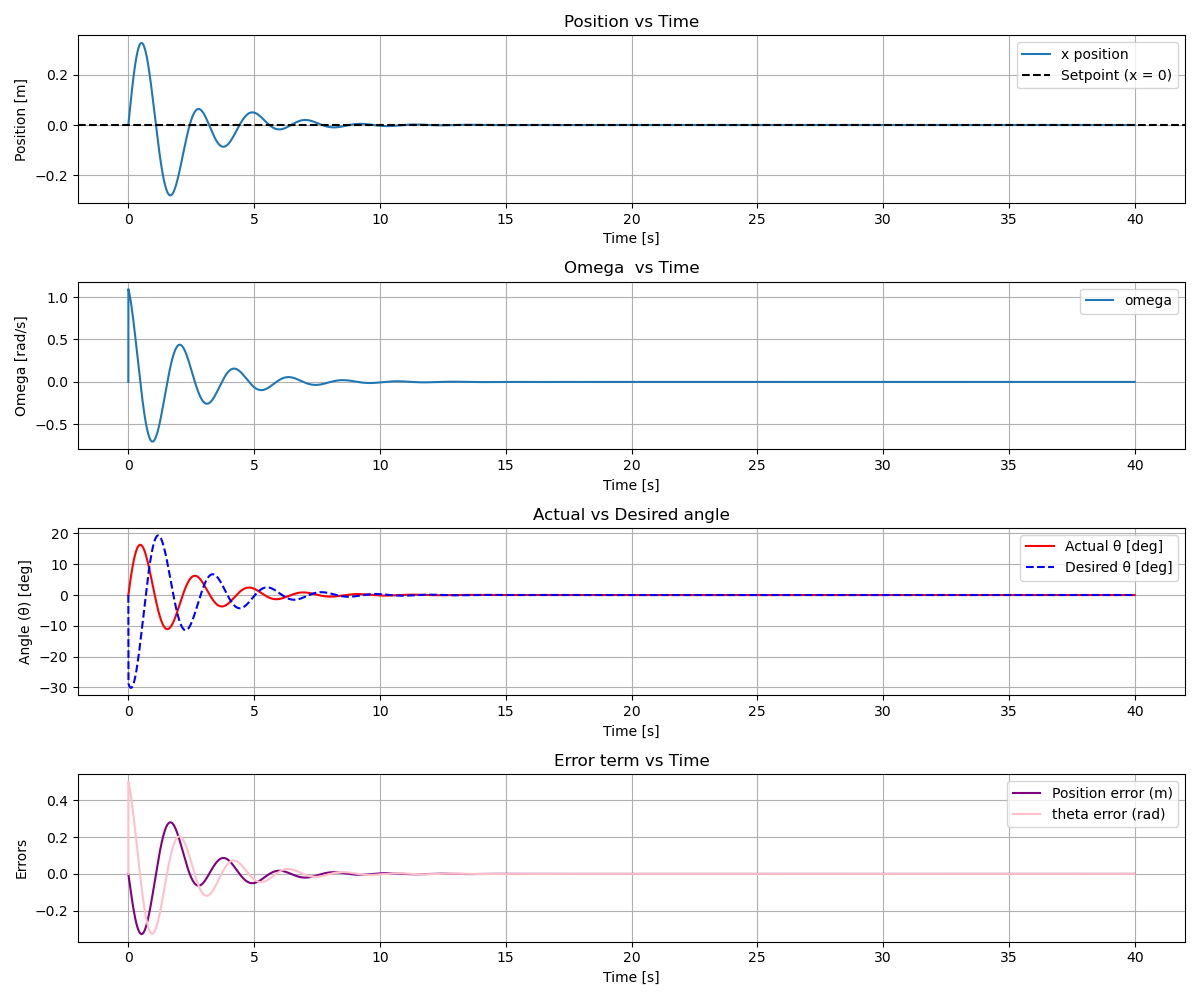

In [42]:
"""
  state = [x, z, vx, vz, theta, omega]
  [0]: position
  [1]: altitudea
  [2]: velocity x
  [3]: velocity z
  [4]: angle
  [5]: angular velocity
"""

#state = np.array([4, 0, 0, 0, -np.pi/5, 0])
state = np.array([0, 0, 1, 0, 0, 0])



pid_gains_attitude = [0.5, 0., 4.5]
pid_gains_position = [0.5, 0.4, .5]

pid_gains = [pid_gains_position, pid_gains_attitude]

# Instantiate drone
drone = DroneSystem(state, pid_gains, m, I_yy, g, k, l, c_d)

# Time span
t_span = (0, 40)
dt = 0.001
t_eval = np.arange(t_span[0], t_span[1], dt)

# Run simulation
time, state_history, outputs, errors = drone.simulate(t_eval)

# Extract states
x = state_history[:, 0]
z = state_history[:, 1]
theta = state_history[:, 4]
omega = state_history[:, 5]


desired_theta = outputs[:, 0]
delta_u = outputs[:, 1]
position_error = errors[:, 0]
theta_error = errors[:, 1]

# --- Plot position ---
plt.figure(figsize=(12, 10))

plt.subplot(4, 1, 1)
plt.plot(time, x, label='x position')
plt.axhline(y=0, color='k', linestyle='--', label='Setpoint (x = 0)')  # Horizontal line at y=0
plt.xlabel('Time [s]')
plt.ylabel('Position [m]')
plt.legend()
plt.grid()
plt.title('Position vs Time')

# --- Plot omega ---

plt.subplot(4, 1, 2)
plt.plot(time, omega, label='omega')
plt.xlabel('Time [s]')
plt.ylabel('Omega [rad/s]')
plt.legend()
plt.grid()
plt.title('Omega  vs Time')

# --- Plot theta desired ---

plt.subplot(4, 1, 3)
plt.plot(time, np.degrees(theta), label='Actual θ [deg]', color='r')
plt.plot(time, np.degrees(desired_theta), '--', label='Desired θ [deg]', color='b')
plt.xlabel('Time [s]')
plt.ylabel('Angle (θ) [deg]')
plt.title('Actual vs Desired angle')
plt.legend()
plt.grid()


# --- Plot error term ---

plt.subplot(4, 1, 4)
plt.plot(time, errors[:, 0], label='Position error (m)', color='purple')
plt.plot(time, errors[:, 1], label='theta error (rad)', color='pink')
plt.xlabel('Time [s]')
plt.ylabel('Errors')
plt.legend()
plt.grid()
plt.title('Error term vs Time')

plt.tight_layout()


plt.show()

In [43]:

import numpy as np
from scipy.signal import StateSpace, tf2ss, ss2tf

# Parameters
g = 9.81  # gravity
m = 1.0   # mass
I_yy = 1.0  # moment of inertia

A = np.array([
    [0, 0, 1, 0, 0, 0],
    [0, 0, 0, 1, 0, 0],
    [0, 0, 0, 0, -g, 0],      # ẍ = g θ (corrected sign)
    [0, 0, 0, 0, 0, 0],      # z̈ = (1/m) * f
    [0, 0, 0, 0, 0, 1],
    [0, 0, 0, 0, 0, 0]       # θ̈ = (1/I_yy) * τ
])

B = np.array([
    [0,     0],
    [0,     0],
    [0,     0],      # No direct input to ẍ
    [1/m,   0],      # f affects z̈
    [0,     0],
    [0, 1/I_yy]      # τ affects θ̈
])

C = np.array([
    [1, 0, 0, 0, 0, 0],  # x
    [0, 1, 0, 0, 0, 0],  # z
    [0, 0, 0, 0, 1, 0]   # theta
])

D = np.zeros((3, 2))

# Create state-space system
sys = StateSpace(A, B, C, D)

# Convert to transfer function form for each input separately
for j in range(B.shape[1]):  # for each input
    # Extract single-input system
    Bj = B[:, j:j+1]
    Dj = D[:, j:j+1]

    # Convert to transfer function
    num, den = ss2tf(A, Bj, C, Dj)

    for i in range(C.shape[0]):  # for each output
        print(f"\nTransfer function from input u{j+1} to output y{i+1}:")
        print(f"Numerator: {num[i]}")
        print(f"Denominator: {den}")


Transfer function from input u1 to output y1:
Numerator: [0. 0. 0. 0. 0. 0. 0.]
Denominator: [1. 0. 0. 0. 0. 0. 0.]

Transfer function from input u1 to output y2:
Numerator: [0. 0. 1. 0. 0. 0. 0.]
Denominator: [1. 0. 0. 0. 0. 0. 0.]

Transfer function from input u1 to output y3:
Numerator: [0. 0. 0. 0. 0. 0. 0.]
Denominator: [1. 0. 0. 0. 0. 0. 0.]

Transfer function from input u2 to output y1:
Numerator: [ 0.00000000e+00  8.88178420e-16 -2.66453526e-15  4.44089210e-15
 -9.81000000e+00  0.00000000e+00  0.00000000e+00]
Denominator: [1. 0. 0. 0. 0. 0. 0.]

Transfer function from input u2 to output y2:
Numerator: [0. 0. 0. 0. 0. 0. 0.]
Denominator: [1. 0. 0. 0. 0. 0. 0.]

Transfer function from input u2 to output y3:
Numerator: [0. 0. 1. 0. 0. 0. 0.]
Denominator: [1. 0. 0. 0. 0. 0. 0.]


In [44]:
import sympy as sp

# Define symbolic variables
s = sp.symbols('s')
m, g, I_yy = sp.symbols('m g I_yy')

# Define symbolic A, B, C, D matrices
A_sym = sp.Matrix([
    [0, 0, 1, 0, 0, 0],
    [0, 0, 0, 1, 0, 0],
    [0, 0, 0, 0, -g, 0],
    [0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 1],
    [0, 0, 0, 0, 0, 0]
])

B_sym = sp.Matrix([
    [0,     0],
    [0,     0],
    [0,     0],
    [1/m,   0],
    [0,     0],
    [0, 1/I_yy]
])

C_sym = sp.Matrix([
    [1, 0, 0, 0, 0, 0],  # x
    [0, 1, 0, 0, 0, 0],  # z
    [0, 0, 0, 0, 1, 0]   # theta
])

D_sym = sp.zeros(3, 2)

# Transfer function: G(s) = C*(sI - A)^(-1)*B + D
I = sp.eye(6)
sI_minus_A = s * I - A_sym
sI_minus_A_inv = sI_minus_A.inv()

G = C_sym * sI_minus_A_inv * B_sym + D_sym
G.simplify()
G


Matrix([
[         0, -g/(I_yy*s**4)],
[1/(m*s**2),              0],
[         0,  1/(I_yy*s**2)]])